In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

def load_images_and_masks(directory):
    images = []
    masks = []

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        
        if filename.startswith('1'):  # Original images
            image = Image.open(filepath).convert('L')
            image = image.resize((128, 128))
            image = np.array(image) / 255.0
            images.append(image)
        
        elif filename.startswith('2'):  # Masks
            mask = Image.open(filepath).convert('L')
            mask = mask.resize((128, 128))
            mask = np.array(mask) / 255.0
            masks.append(mask)
    
    return np.array(images), np.array(masks)

selected_images_dir = 'selected_images_1500'
images, masks = load_images_and_masks(selected_images_dir)

# Check consistency
def check_consistency(images, masks):
    if len(images) != len(masks):
        print("Number of images and masks are not consistent.")
        return False
    else:
        print("Number of images and masks are consistent.")
        return True

if not check_consistency(images, masks):
    exit()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)




Number of images and masks are consistent.


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization

def unet_with_batch_norm(input_shape):
    inputs = Input(input_shape)

    # Downscaling path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)

    # Upscaling path
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([up1, conv2], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([up2, conv1], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define input shape
input_shape = (128, 128, 1)

# Create and compile U-Net model
unet_bn_model = unet_with_batch_norm(input_shape)
unet_bn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the U-Net model
history = unet_bn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=4)

# Evaluate the U-Net model
loss, accuracy = unet_bn_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Print layer names for feature extraction
for layer in unet_bn_model.layers:
    print(layer.name)


Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.1925 - loss: 0.7786 - val_accuracy: 0.3420 - val_loss: 0.6108
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.2771 - loss: 0.6392 - val_accuracy: 0.3420 - val_loss: 0.6053
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.2749 - loss: 0.6297 - val_accuracy: 0.3420 - val_loss: 0.6048
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.2969 - loss: 0.6237 - val_accuracy: 0.2144 - val_loss: 0.6645
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.3074 - loss: 0.6113 - val_accuracy: 0.3420 - val_loss: 0.6025
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.3157 - loss: 0.6124 - val_accuracy: 0.3420 - val_loss: 0.6202
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.2924 - loss: 0.6211 - val_accuracy: 0.3420 - val_loss: 0.5962
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.2937 - loss: 0.6248 - val_accuracy: 0.3420 - val_loss

In [9]:
from tensorflow.keras.models import Model
import numpy as np

# Select the layer from which you want to extract features
feature_layer_name = 'conv2d_5'
feature_extractor_model = Model(inputs=unet_bn_model.input, outputs=unet_bn_model.get_layer(feature_layer_name).output)

# Extract features for training and testing datasets
train_features = feature_extractor_model.predict(X_train)
test_features = feature_extractor_model.predict(X_test)

# Check the shape of extracted features
print(f'Train features shape: {train_features.shape}')
print(f'Test features shape: {test_features.shape}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 775ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Train features shape: (239, 32, 32, 256)
Test features shape: (60, 32, 32, 256)


In [10]:
# Flatten the features
train_features_flattened = train_features.reshape(train_features.shape[0], -1)
test_features_flattened = test_features.reshape(test_features.shape[0], -1)

# Check the flattened feature shapes
print(f'Flattened train features shape: {train_features_flattened.shape}')
print(f'Flattened test features shape: {test_features_flattened.shape}')


Flattened train features shape: (239, 262144)
Flattened test features shape: (60, 262144)


In [11]:
from tensorflow.keras.utils import to_categorical

# Assuming y_train and y_test are your label arrays
# Convert labels to categorical if necessary
y_train_labels = to_categorical(y_train, num_classes=2)  # Update num_classes if necessary
y_test_labels = to_categorical(y_test, num_classes=2)

# Check the shape of the labels
print(f'Shape of y_train_labels: {y_train_labels.shape}')
print(f'Shape of y_test_labels: {y_test_labels.shape}')


Shape of y_train_labels: (239, 128, 128, 2)
Shape of y_test_labels: (60, 128, 128, 2)


In [12]:
# Flatten the labels for classification
y_train_labels_flattened = y_train_labels.reshape(y_train_labels.shape[0], -1, y_train_labels.shape[-1])
y_test_labels_flattened = y_test_labels.reshape(y_test_labels.shape[0], -1, y_test_labels.shape[-1])

# Check the flattened label shapes
print(f'Flattened y_train_labels shape: {y_train_labels_flattened.shape}')
print(f'Flattened y_test_labels shape: {y_test_labels_flattened.shape}')


Flattened y_train_labels shape: (239, 16384, 2)
Flattened y_test_labels shape: (60, 16384, 2)


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

def create_vit_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Dense(512, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define input shape for ViT
input_shape_vit = (train_features_flattened.shape[1],)  # Flattened feature shape
num_classes = 2  # Number of classes

# Create and compile Vision Transformer model
vit_model = create_vit_model(input_shape_vit, num_classes)
vit_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
# Convert pixel-level labels to image-level labels
y_train_labels_single = np.argmax(y_train_labels_flattened.mean(axis=1), axis=-1)
y_test_labels_single = np.argmax(y_test_labels_flattened.mean(axis=1), axis=-1)

# Convert to categorical
y_train_labels_single = tf.keras.utils.to_categorical(y_train_labels_single, num_classes=2)
y_test_labels_single = tf.keras.utils.to_categorical(y_test_labels_single, num_classes=2)

# Check the new shape of labels
print(f'Shape of y_train_labels_single: {y_train_labels_single.shape}')
print(f'Shape of y_test_labels_single: {y_test_labels_single.shape}')


Shape of y_train_labels_single: (239, 2)
Shape of y_test_labels_single: (60, 2)


In [15]:
# Train the Vision Transformer model
history = vit_model.fit(
    train_features_flattened, 
    y_train_labels_single, 
    validation_data=(test_features_flattened, y_test_labels_single), 
    epochs=10, 
    batch_size=4
)

# Evaluate the Vision Transformer model
loss, accuracy = vit_model.evaluate(test_features_flattened, y_test_labels_single)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.5835 - loss: 492.5407 - val_accuracy: 0.7333 - val_loss: 339.8163
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5892 - loss: 616.6078 - val_accuracy: 0.7333 - val_loss: 300.9352
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5570 - loss: 428.0362 - val_accuracy: 0.6667 - val_loss: 91.3384
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.6115 - loss: 283.1037 - val_accuracy: 0.6667 - val_loss: 90.3914
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.6122 - loss: 171.7394 - val_accuracy: 0.7333 - val_loss: 86.5747
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.6946 - loss: 121.5807 - val_accuracy: 0.6167 - val_loss: 38.0640
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.6371 - loss: 93.2745 - val_accuracy: 0.7500 - val_loss: 31.9250
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.5603 - loss: 74.5486 - val_accu

In [16]:
# Save the Vision Transformer model
vit_model.save('vit_model_batch_norm.h5')


In [18]:
from tensorflow.keras.models import load_model

# Load the Vision Transformer model
vit_model = load_model('vit_model_batch_norm.h5')


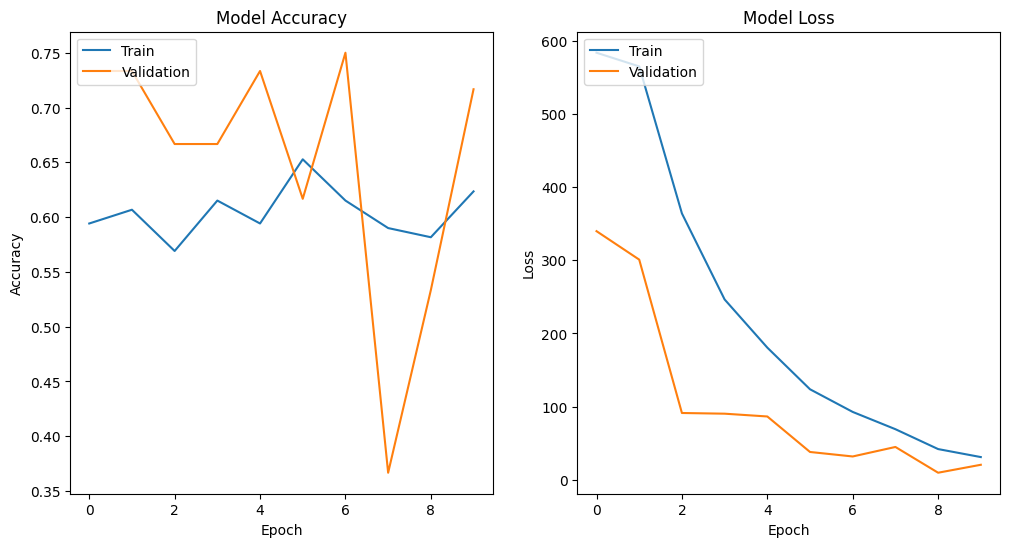

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
